In [59]:
import numpy as np
import scipy
from matplotlib import pyplot

In [79]:
SPATIAL_SAMPLING_RATE = 2200.0
FILTER_TAPS = 2000
REFERENCE_ROUGHNESS = 1e-6

In [67]:
def make_noise(filter_taps):
    return np.sqrt(SPATIAL_SAMPLING_RATE / 2) * np.random.normal(size=(filter_taps,))

In [68]:
make_noise(10)

array([-62.13327821,  19.89447856, -50.24573562, -70.63753235,
       -46.40777825,   2.33331901,   4.81041761,  10.99429109,
       -33.25263015,  13.73355933])

In [69]:
def third_octave_band_center(j):
    return 2.0 ** ((j+0.5) / 3.0)
def third_octave_band_width(j):
    return 2.0 ** ((j+1) / 3.0) - 2.0 ** (j / 3.0)

In [70]:
np.sum(third_octave_band_width(np.array([0, 1, 2])))

1.0

In [117]:
Lrtr = np.linspace(10.0, -10.0, 30); Lrtr
# Lrtr = np.array([5.0, 3.0, 2.0, 0.0, 1.0, 0.0, 1.0, -2.0, -3.0, -4.0, -5.0, -6.0, -7.0, -8.0])

array([ 10.        ,   9.31034483,   8.62068966,   7.93103448,
         7.24137931,   6.55172414,   5.86206897,   5.17241379,
         4.48275862,   3.79310345,   3.10344828,   2.4137931 ,
         1.72413793,   1.03448276,   0.34482759,  -0.34482759,
        -1.03448276,  -1.72413793,  -2.4137931 ,  -3.10344828,
        -3.79310345,  -4.48275862,  -5.17241379,  -5.86206897,
        -6.55172414,  -7.24137931,  -7.93103448,  -8.62068966,
        -9.31034483, -10.        ])

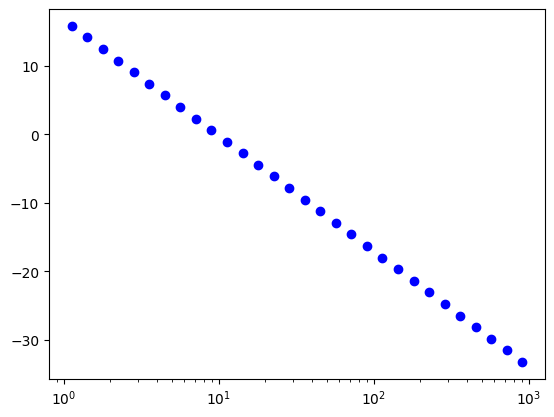

In [118]:
roughness_indices = np.arange(*Lrtr.shape)
roughness_wavenumbers = third_octave_band_center(roughness_indices)
roughness_values = Lrtr - 10 * np.log10(third_octave_band_width(roughness_indices))

pyplot.xscale('log')
pyplot.plot(roughness_wavenumbers, roughness_values, 'bo')

In [119]:
def extrapolate(x_to_find, x, y):
    m, b = np.polyfit(x, y, 1)
    return m * x_to_find + b

In [120]:
roughness_0, roughness_nyquist = extrapolate(np.array((0.0, SPATIAL_SAMPLING_RATE / 2)), roughness_wavenumbers, roughness_values)
roughness_0, roughness_nyquist

(-1.3377966309389817, -56.31840860671854)

These ^ values seem weird but we'll roll with it for now. (I mean, I understand why they're like that, but I'm not sure that this kind of linear extrapolation is quite what is desired.) I'm not sure the _0 value will really matter much anyway, since that will correspond to DC roughness and we end up differentiating.

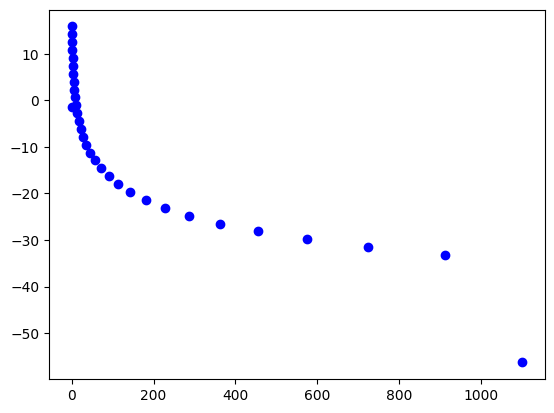

In [121]:
roughness_wavenumbers_full = np.concatenate(([0.0], roughness_wavenumbers, [SPATIAL_SAMPLING_RATE/2]))
roughness_values_full = np.concatenate(([roughness_0], roughness_values, [roughness_nyquist]))
pyplot.plot(roughness_wavenumbers_full, roughness_values_full, 'bo')

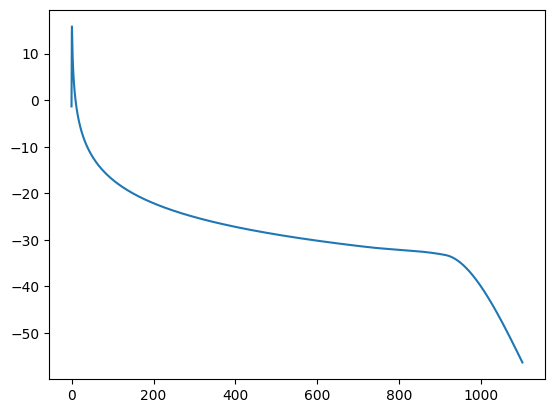

In [132]:
roughness_interpolator = scipy.interpolate.PchipInterpolator(roughness_wavenumbers_full, roughness_values_full)
roughness_fftfreq = scipy.fft.rfftfreq(8192, d=1/SPATIAL_SAMPLING_RATE)
roughness_interpolated = roughness_interpolator(roughness_fftfreq)
pyplot.plot(roughness_fftfreq, roughness_interpolated)

In [133]:
h_basic = scipy.fft.irfft(REFERENCE_ROUGHNESS * 10.0 ** (roughness_interpolated / 20.0))
h_basic

array([8.05862646e-08, 5.58886287e-08, 4.19938025e-08, ...,
       4.05005003e-08, 4.19938025e-08, 5.58886287e-08])

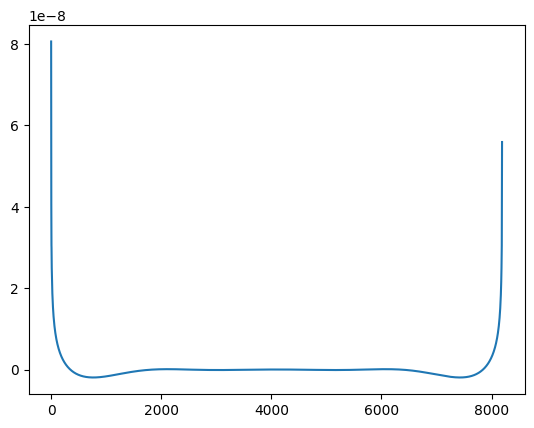

In [134]:
pyplot.plot(h_basic)

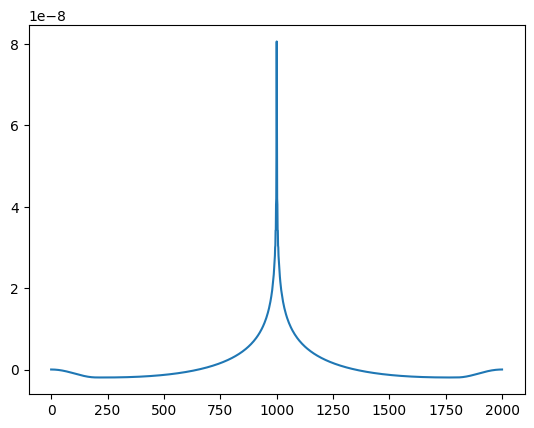

In [140]:
h_track = np.concatenate((h_basic[-FILTER_TAPS//2:], h_basic[:FILTER_TAPS//2])) * scipy.signal.windows.tukey(FILTER_TAPS, alpha=0.2)
pyplot.plot(h_track)

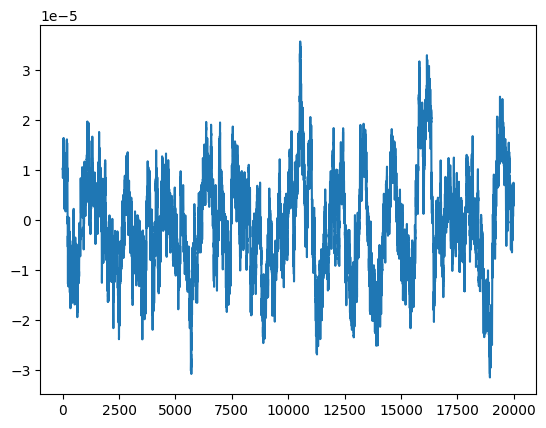

In [146]:
alotta_noise = make_noise(int(SPATIAL_SAMPLING_RATE * 10))
filtered_noise = np.convolve(alotta_noise, h_track, mode='valid')
pyplot.plot(filtered_noise)